## Life history traits model   

Taylor Chapter 3  
model to predict age-structured life history traits of understudied Carcharhinid species

Model version: mixed effects, uses average depth, litter & offspring (not relative), no habitat. Most S covariates stripped out according to results from comparing models 10 & 11.  

covariates here are mean centred rather than z scores in order to make output for prediction script.  Need this because effect sizes need to be on the same scale as the raw data in order to calculate predicted values for a50 and s


### Set up notebook

In [12]:
#import packages
import datetime 
from itertools import product
import logging
import pickle
import numpy as np
import pandas as pd
import scipy as sp
import os
from math import isnan
from sklearn.preprocessing import LabelEncoder
from collections import Counter
import seaborn as sns
import pymc3 as pm  
from theano import tensor as tt
from theano import shared
import arviz as az
import warnings

%matplotlib inline  
#%matplotlib inline is a magic function that renders the figure in a notebook (instead of displaying a dump of the figure object)
from matplotlib import pyplot as plt 
from matplotlib.offsetbox import AnchoredText
from matplotlib.ticker import FuncFormatter, StrMethodFormatter


In [13]:
# Aaron Helper function
def indexall(L):
    poo = []
    for p in L:
        if not p in poo:
            poo.append(p)
    Ix = np.array([poo.index(p) for p in L])
    return poo,Ix

def subindexall(short,long):
    poo = []
    out = []
    for s,l in zip(short,long):
        if not l in poo:
            poo.append(l)
            out.append(s)
    return indexall(out)

match = lambda a, b: [ b.index(x) if x in b else None for x in a ]
grep = lambda s, l: np.array([i for i in l if s in i])

# Function to standardize covariates
def stdise(x):
    return (x-np.mean(x))/(np.std(x)*2)

# Function to mean-centre covariates
def centre(x):
    return (x-np.mean(x))

def invlogit(x):
    return np.exp(x)/(1+np.exp(x))

def gelplot(pj,vector,posy,csize=40,lwd50=7,lwd95=1):
    if np.percentile(vector,2.5)<0 and 0<np.percentile(vector,97.5):
        pj.plot(np.median(vector),posy,'.',markersize=csize,c='grey')
        pj.plot((np.percentile(vector,2.5),np.percentile(vector,97.5)),(posy,posy),linewidth=lwd95,c='grey')
        pj.plot((np.percentile(vector,25),np.percentile(vector,75)),(posy,posy),linewidth=lwd50,c='grey')
    else:
        pj.plot(np.median(vector),posy,'.',markersize=csize,c='black')
        pj.plot((np.percentile(vector,2.5),np.percentile(vector,97.5)),(posy,posy),linewidth=lwd95,c='black')
        pj.plot((np.percentile(vector,25),np.percentile(vector,75)),(posy,posy),linewidth=lwd50,c='black')
        
    if np.percentile(vector,25)<0 and 0<np.percentile(vector,75):
        pj.plot(np.median(vector),posy,'.',markersize=csize,c='white')

In [14]:
os.chdir('C:\\Users\\tmgor\\Dropbox\\Taylor Chapter 3\\Predict_Maturity\\Data\\for model\\in')
os.listdir() # list files in directory

['age_structured_traits.xlsx',
 'car_trait_covariates_v2.xlsx',
 'full_dataset.xlsx',
 'species_level_traits_v1.xlsx',
 'tmp_car_traits.xlsx',
 '~$car_trait_covariates_v2.xlsx',
 '~$full_dataset.xlsx']

### Import and structure data

In [15]:
# Import full dataset
data = pd.read_excel('full_dataset.xlsx')
#get rid of species that don't have full complement of trait data
data = data[data.param_complete==0]
data.head()

,Species,Stock,Stock_Year,Age,maturity,survivorship,fecundity (num female pups per year),notes,model type,source_mat,...,linf_cm,growth_coeff_k,lmax_cm,age_max_yrs,temp_pref,nursery,depth_min,depth_max,depth_ave,param_complete
0,Carcharhinus tilstoni,ABTP-SWP,ABTP-SWP-13,0,0.000000,NaN,NaN,NaN,NaN,Harry 2013,...,218.0,0.089,166.0,15.0,23.0,0.0,0.0,150.0,75.0,0.0
1,Carcharhinus tilstoni,ABTP-SWP,ABTP-SWP-13,1,0.000000,NaN,NaN,NaN,NaN,Harry 2013,...,218.0,0.089,166.0,15.0,23.0,0.0,0.0,150.0,75.0,0.0
2,Carcharhinus tilstoni,ABTP-SWP,ABTP-SWP-13,2,0.000000,NaN,NaN,NaN,NaN,Harry 2013,...,218.0,0.089,166.0,15.0,23.0,0.0,0.0,150.0,75.0,0.0
3,Carcharhinus tilstoni,ABTP-SWP,ABTP-SWP-13,3,0.000000,NaN,NaN,NaN,NaN,Harry 2013,...,218.0,0.089,166.0,15.0,23.0,0.0,0.0,150.0,75.0,0.0
4,Carcharhinus tilstoni,ABTP-SWP,ABTP-SWP-13,4,0.016088,NaN,NaN,NaN,NaN,Harry 2013,...,218.0,0.089,166.0,15.0,23.0,0.0,0.0,150.0,75.0,0.0


In [16]:
#list columns
data.columns

Index(['Species', 'Stock', 'Stock_Year', 'Age', 'maturity', 'survivorship',
       'fecundity (num female pups per year)', 'notes', 'model type',
       'source_mat', 'source_sur', 'source_fec', 'source_m_link',
       'source_s_link', 'source_f_link', 'Cortes_2018', 'SA_mat', 'SA_sur',
       'SA_fec', 'FP_species', 'habitat', 'trophic_level', 'offspring_size_mm',
       'litter_size', 'interbirth_interval_yrs', 'age_50_maturity',
       'length_maturity_cm', 'linf_cm', 'growth_coeff_k', 'lmax_cm',
       'age_max_yrs', 'temp_pref', 'nursery', 'depth_min', 'depth_max',
       'depth_ave', 'param_complete'],
      dtype='object')

In [17]:
# make datafame of only stocks which have age-structured maturity data
# only data rows where SA-mat A
mdata= data[data.SA_mat=='A']
mdata.shape

(505, 37)

In [18]:
# make sure data is sorted properly
mdata = mdata.sort_values(by=['Stock_Year', 'Age'])

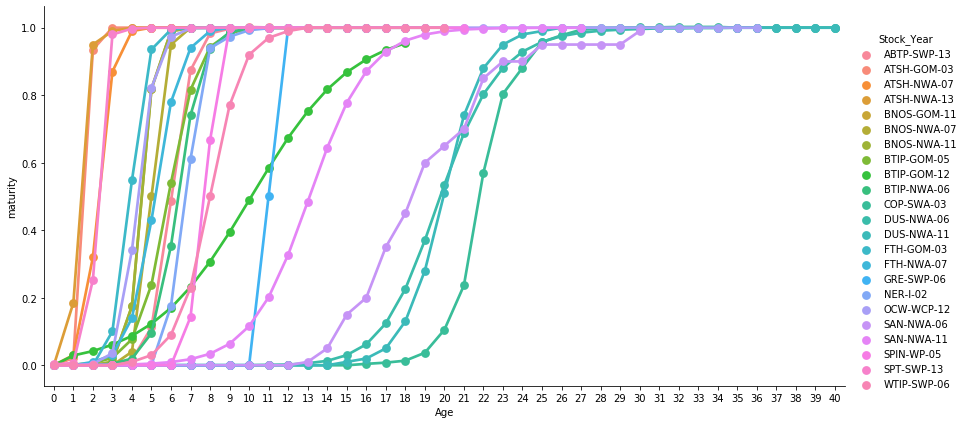

In [19]:
# visualise age-structured data
sns.catplot(x = "Age", y = "maturity", hue = "Stock_Year", height=6, aspect=2,
                kind="point", data = mdata);

## Format data

In [20]:
# Make arrays of response variables
AGE = mdata.Age.values
nobs = len(AGE)
MAT = mdata.maturity.values

In [21]:
# Make an index for stock-years 
# Puts an index value unique to the stock year for each row in df
StockYr, Is = indexall(mdata.Stock_Year.values)
nstocks = len(StockYr)
StockYr

['ABTP-SWP-13',
 'ATSH-GOM-03',
 'ATSH-NWA-07',
 'ATSH-NWA-13',
 'BNOS-GOM-11',
 'BNOS-NWA-07',
 'BNOS-NWA-11',
 'BTIP-GOM-05',
 'BTIP-GOM-12',
 'BTIP-NWA-06',
 'COP-SWA-03',
 'DUS-NWA-06',
 'DUS-NWA-11',
 'FTH-GOM-03',
 'FTH-NWA-07',
 'GRE-SWP-06',
 'NER-I-02',
 'OCW-WCP-12',
 'SAN-NWA-06',
 'SAN-NWA-11',
 'SPIN-WP-05',
 'SPT-SWP-13',
 'WTIP-SWP-06']

In [22]:
#Index of covariates
Sind = np.array([list(mdata.Stock_Year.values).index(S) for S in StockYr])

#make arrays of all the covariates
#put Sind after all of these so they match the length of StockYr
rLMAX = mdata.lmax_cm.values[Sind]
rHAB = mdata.habitat.values[Sind]
rTROPH = mdata.trophic_level.values[Sind]
rOFFSZ = mdata.offspring_size_mm.values[Sind]
#rROFFSZ = mdata.relative_offspring_size.values[Sind]
rLITT = mdata.litter_size.values[Sind]
#RLITT = mdata.relative_litter_size.values[Sind]
rINTR = mdata.interbirth_interval_yrs.values[Sind]
rAMAT = mdata.age_50_maturity.values[Sind]
rLMAT = mdata.length_maturity_cm.values[Sind]
rLINF = mdata.linf_cm.values[Sind]
rK = mdata.growth_coeff_k.values[Sind]
rAMAX = mdata.age_max_yrs.values[Sind]
rDEP = mdata.depth_ave.values[Sind]
rDEPMAX = mdata.depth_max.values[Sind]

In [25]:
np.mean(rDEP)

121.95652173913044

In [24]:
# mean centre all covariates
#change variable names

LMAX = centre(np.log(rLMAX))
TROPH = centre(rTROPH)
OFFSZ = centre(rOFFSZ/100)
LITT = centre(np.log(rLITT))
INTR = centre(rINTR)
LMAT = centre(rLMAT)
LINF = centre(np.log(rLINF))
K = centre(rK)
AMAX = centre(np.log(rAMAX))
DEP = centre(np.log(rDEP+1))
DEPMAX = centre(np.log(rDEPMAX+1))
#need to transform habitat somehow?

In [77]:
INTR

array([-0.86956522, -0.86956522, -0.86956522, -0.86956522,  0.13043478,
        0.13043478,  0.13043478,  0.13043478,  0.13043478,  0.13043478,
        0.13043478,  1.13043478,  1.13043478,  0.13043478,  0.13043478,
        0.13043478,  0.13043478,  0.13043478,  0.13043478,  0.13043478,
        0.13043478, -0.86956522,  0.13043478])

# Bayes model

Maturity model has 2 parts to assess the 2 parameters which describe the maturity curve

$$m = \frac{1}{1+e^{-S}(a-a_{50})}$$


a50 null model:
$$
\small{
a_{50} \sim Normal(Ga_{50},\sigma a_{50}) \\ 
Ga_{50} \sim Uniform(1.5, 25)  \\
\sigma a_{50} \sim Exponential(0.5) 
}
$$



S null model:
$$
\small{
S \sim Normal(GS,\sigma S) \\
GS \sim Uniform(0.01, 10)  \\
\sigma S \sim Exponential(1) 
}
$$

### Visualise Priors

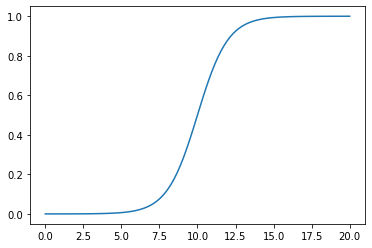

In [28]:
#make a figure of sigmoid with example maturity equation
def sigmoid(a):
    return(1/(1+np.exp(-1*(a-10))))
a = np.linspace(0,20,100)
plt.plot(a, sigmoid(a))

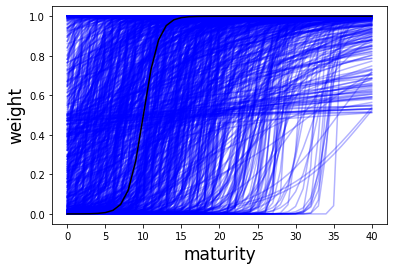

In [29]:
# try to visualise maturity slopes with prior a50 and S values
nsamp = 1000
a50 = np.random.normal(10, 10, nsamp)
S = np.random.exponential(1, nsamp)

ages = mdata.Age.unique()

#plot all possible ogives
[plt.plot(ages, 1/(1+np.exp(-S*(ages-a50))), c='blue', alpha=0.3) for a50,S in zip(a50, S)]
plt.xlabel('age', fontsize=10)
plt.ylabel('maturity', fontsize=10);

# a real ogive to see
plt.plot(ages, sigmoid(ages), c='black')

# Make it look nice
plt.xlabel('maturity', fontsize=17)
plt.ylabel('weight', fontsize=17);

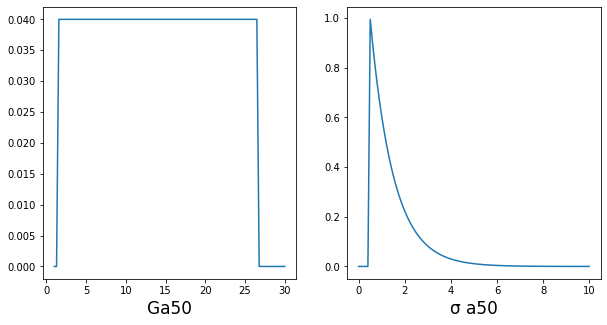

In [30]:
#visualise a50 priors here

# Setup multipanel figure
nrows, ncols = 1, 2
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10,5))
ax_ = axes.flatten()

# Plot range of Ga50 prior
# create 100 values between 1 and 30
x = np.linspace(1, 30, 100) 
ax_[0].plot(x, sp.stats.uniform.pdf(x, 1.5, 25))
# specify labels for chart 1
ax_[0].set_xlabel('Ga50', fontsize=17)

# Plot range of sigma prior
#create 100 values between -10 and 60
x = np.linspace(0, 10, 100)
#what is the likelihood of each potential sigma value given your uniform prior where the mean=0 and std dev=50
ax_[1].plot(x, sp.stats.expon.pdf(x, 0.5))
ax_[1].set_xlabel('σ a50', fontsize=17);

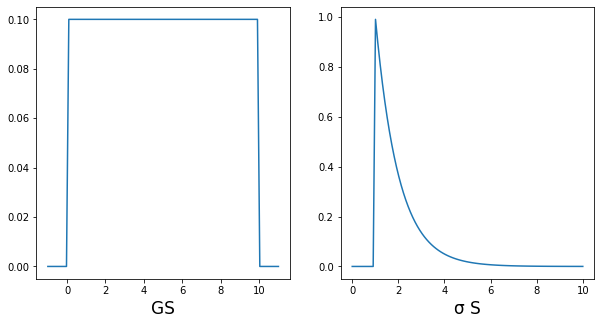

In [31]:
#visualise S priors here

# Setup multipanel figure
nrows, ncols = 1, 2
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10,5))
ax_ = axes.flatten()

# Plot range of GS prior
x = np.linspace(-1, 11, 100) #make the x axis
ax_[0].plot(x, sp.stats.uniform.pdf(x, 0.01, 10))
# specify labels for chart 1
ax_[0].set_xlabel('GS', fontsize=17)

# Plot range of sigma prior
#create 100 values between -10 and 60
x = np.linspace(0, 10, 100)
#what is the likelihood of each potential sigma value given your uniform prior where the mean=0 and std dev=50
ax_[1].plot(x, sp.stats.expon.pdf(x, 1))
ax_[1].set_xlabel('σ S', fontsize=17);

### Model Specification

In [4]:
# random effects model with stripped out S
with pm.Model() as mat2:
    
    # Hierarchical a50
    Ga50 = pm.Uniform('Ga50', 1.5, 25) #mean a50 has uniform distribution from 1.5 to 25
    a50_sigma = pm.Exponential('a50_sigma', 0.5) #std dev of a50 is exponential distribution with lambda of 0.5
    a50 = pm.Normal('a50x', Ga50, a50_sigma, shape=nstocks) #likelihood of a50 values given distributions of Ga50 and sigma_a50, 1 dist. per stockyear 
    # set up priors for slope values between a50 and covariates
    # first argument is just a name not an actual dataset - doesn't need to match name of data array
    β1 = pm.Normal('Lmax', 0, 3) 
   # β2 = pm.Normal('Linf', 0, 3) # don't use Linf bc same thing as Lmax, also effect too similar to K
    β3 = pm.Normal('Depth', 0, 3)
   # β4 = pm.Normal('K', 0, 3)
   # β5 = pm.Normal ('Habitat', 0, 3) # How to set this up for a categorical variable?
    β6 = pm.Normal('Interbirth_interval', 0, 3)
    β7 = pm.Normal('Amax', 0, 3)
    β8 = pm.Normal('Litter', 0, 3)
    β9 = pm.Normal('Offspring_size', 0, 3)
    β10 = pm.Normal('Trophic', 0, 3)
  #  β11 = pm.Normal('Lmat', 0, 3)  # Don't use Lmat because same thing as a50
    
    # Hierarchical S
    # S is the curve parameter determining steepness/shape of maturity curve
    # GS is mean of distribution describing what S is
    # S_sigma is standard dev of distribution around GS
    GS = pm.Uniform('GS', 0.01, 10) # Uniform distribution of possible S values from 0.01 to 10
    S_sigma = pm.Exponential('S_sigma', 1) #Exponential distribution of possible sigma values with lambda of 1
    S = pm.Normal('Sx', GS, S_sigma, shape=nstocks) 
    
    # priors for covariates of S
   # B1 = pm.Normal('Lmax-S', 0, 3)
   # B3 = pm.Normal('Depth-S', 0, 3)
    B4 = pm.Normal('K-S', 0, 3)
   # β5 = pm.Normal ('Habitat', 0, 3) # How to set this up for a categorical variable?
   # B6 = pm.Normal('Interbirth_interval-S', 0, 3)
    B7 = pm.Normal('Amax-S', 0, 3)
   # B8 = pm.Normal('Litter-S', 0, 3)
   # B9 = pm.Normal('Offspring_size-S', 0, 3)
    B10 = pm.Normal('Trophic-S', 0, 3)
    # no lmat because treating S and a50 as if they behave separately
    
    
    # a50 model
    # put all parameters that influence a50 here (all the β params from above)
    mu_a50 = pm.Deterministic("mu_a50", a50 + β1*LMAX + β3*DEP + β6*INTR + β7*AMAX + β8*LITT + β9*OFFSZ + β10*TROPH)
    #mu_a50 = pm.Deterministic("mu_a50", a50 + β1*LMAX) #try running model with 1 covariate to test for overfitting
 
    # Growth (S) model
    mu_S = pm.Deterministic("mu_S", S + B4*K + B7*AMAX + B10*TROPH)
    
    # Growth model
    mu = 1/(1+tt.exp(-mu_S[Is]*(AGE-mu_a50[Is])))
    #mu = 1/(1+tt.exp(-S[Is]*(AGE-mu_a50[Is])))
    #mu = 1/(1+tt.exp(-S[Is]*(AGE-a50[Is])))

    # Likelihood
    S2 = pm.Uniform('S2', 0.0, 0.1) #variance for likelihood equation
    Yi = pm.Normal('Yi', mu, S2, observed=MAT)
    

NameError: name 'nstocks' is not defined

In [35]:
for rv in mat2.basic_RVs:
    print(rv.name, rv.logp(mat2.test_point))

Ga50_interval__ -1.3862943611198906
a50_sigma_log__ -1.0596601002984287
a50x -28.64817430640816
Lmax -2.0175508218727827
Depth -2.0175508218727827
Interbirth_interval -2.0175508218727827
Amax -2.0175508218727827
Litter -2.0175508218727827
Offspring_size -2.0175508218727827
Trophic -2.0175508218727827
GS_interval__ -1.3862943611198906
S_sigma_log__ -1.0596601002984287
Sx -12.705789153529404
K-S -2.0175508218727827
Amax-S -2.0175508218727827
Trophic-S -2.0175508218727827
S2_interval__ -1.3862943611198904
Yi -28670.6496425569


In [81]:
# Sampling
# go back to 5000 for final run
with mat2:
    trace2 = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [S2, Trophic-S, Amax-S, K-S, Sx, S_sigma, GS, Trophic, Offspring_size, Litter, Amax, Interbirth_interval, Depth, Lmax, a50x, a50_sigma, Ga50]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 19552 seconds.
There were 28 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


C:\ProgramData\Anaconda3\lib\site-packages\arviz\data\io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


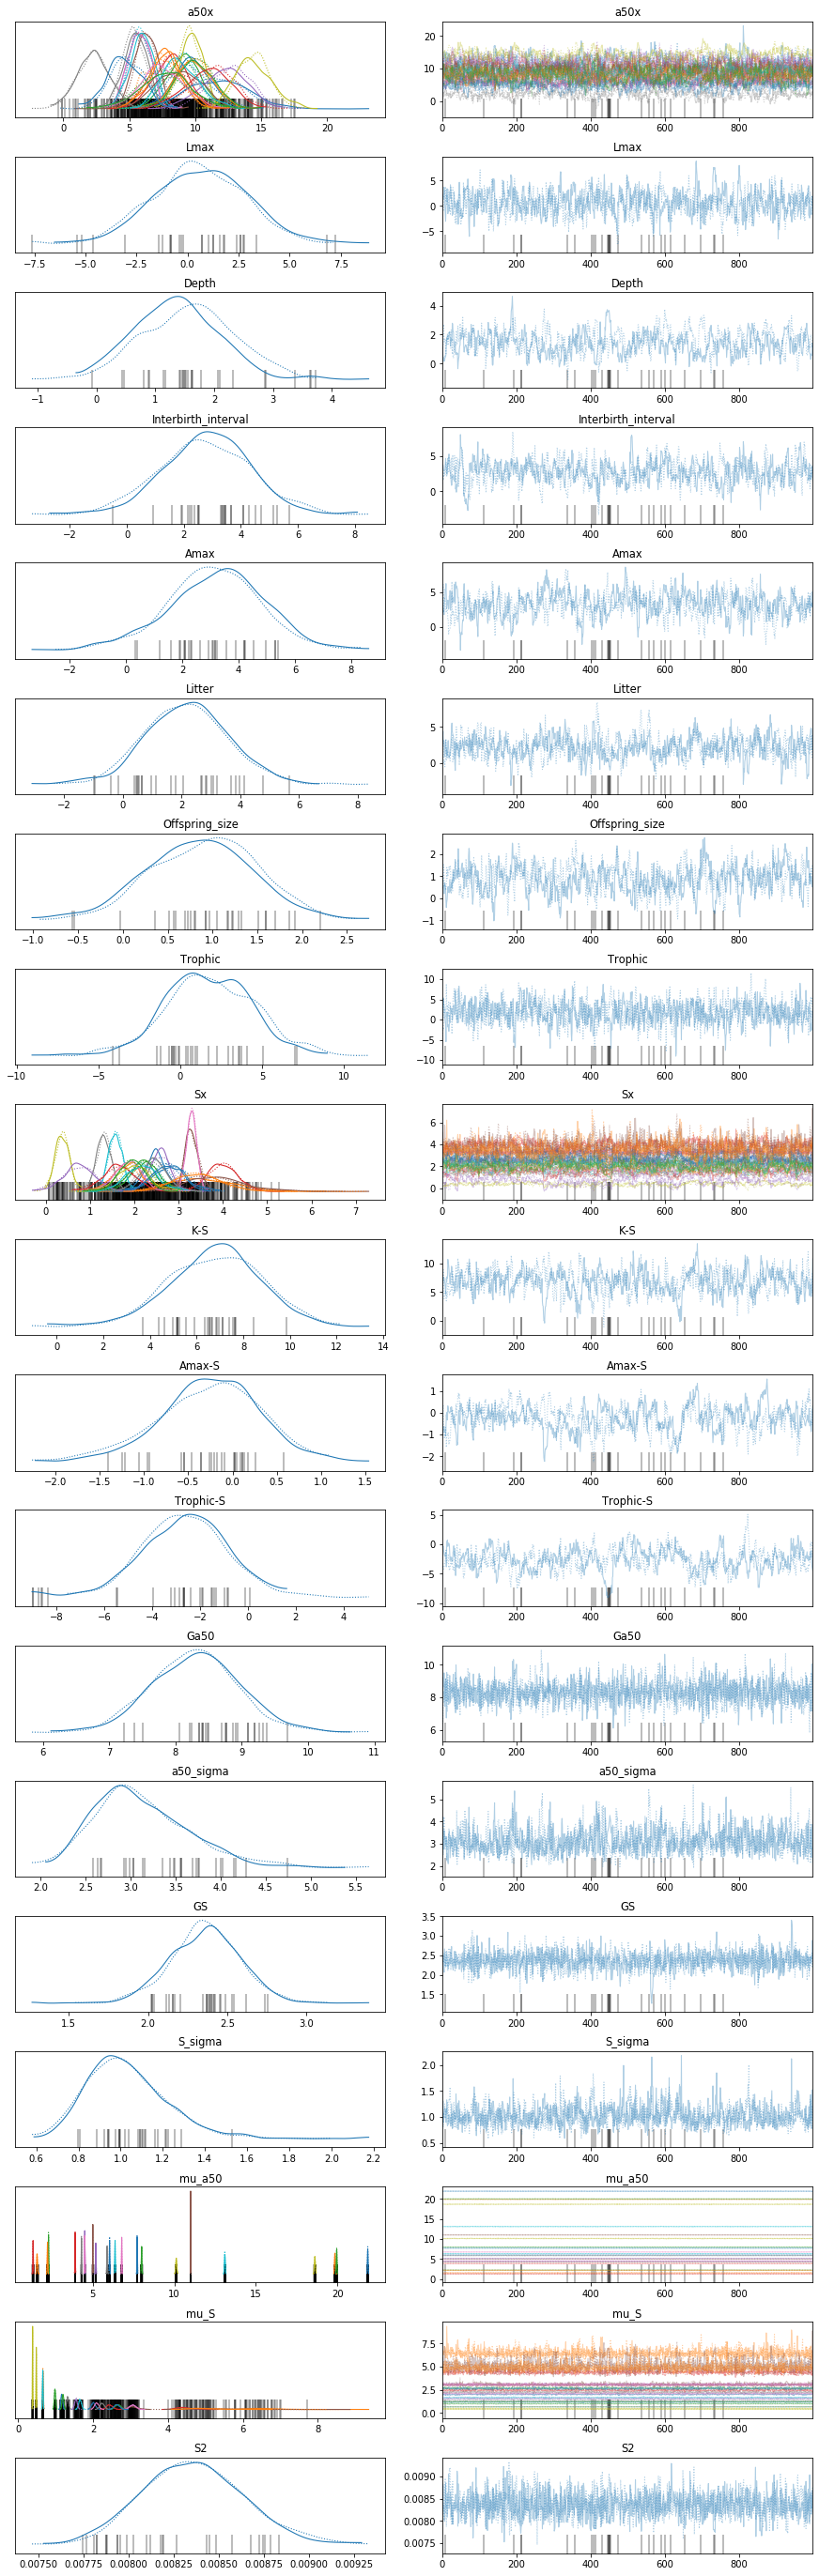

In [82]:
#check model performance
pm.traceplot(trace2);

In [83]:
pm.summary(trace2)
# looking for r-hat valeus of 1 - shows that model is converging

C:\ProgramData\Anaconda3\lib\site-packages\arviz\data\io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a50x[0],9.661,1.528,6.920,12.628,0.090,0.064,288.0,288.0,287.0,463.0,1.00
a50x[1],7.568,1.271,5.367,10.032,0.088,0.063,209.0,207.0,210.0,300.0,1.01
a50x[2],8.931,1.352,6.559,11.546,0.094,0.066,209.0,209.0,207.0,314.0,1.01
a50x[3],7.983,1.352,5.574,10.577,0.093,0.066,209.0,209.0,207.0,314.0,1.01
a50x[4],5.830,0.872,4.238,7.474,0.059,0.042,222.0,220.0,223.0,389.0,1.01
...,...,...,...,...,...,...,...,...,...,...,...
mu_S[19],0.657,0.009,0.639,0.675,0.000,0.000,1987.0,1987.0,1990.0,1531.0,1.00
mu_S[20],2.633,0.075,2.501,2.782,0.002,0.001,2064.0,2054.0,2074.0,1240.0,1.00
mu_S[21],4.920,0.389,4.273,5.667,0.009,0.007,1702.0,1529.0,2548.0,1183.0,1.00
mu_S[22],1.196,0.024,1.155,1.243,0.001,0.000,1865.0,1865.0,1863.0,1441.0,1.00


In [84]:
#Save traces for use in prediction
os.chdir('C:\\Users\\tmgor\\Dropbox\\Taylor Chapter 3\\Predict_Maturity\\Data\\for model\\out\\traces')
pm.save_trace(trace2)

'.pymc_4.trace'

### Model Results

C:\ProgramData\Anaconda3\lib\site-packages\arviz\data\io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


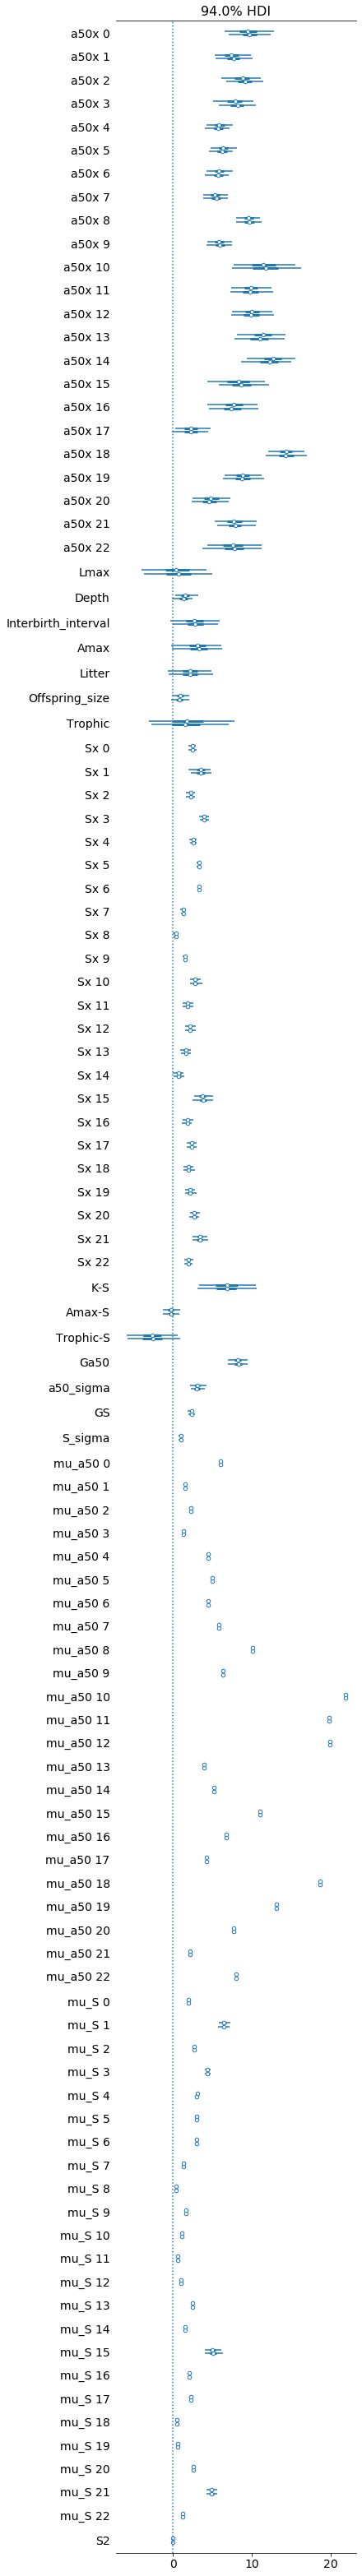

<Figure size 432x288 with 0 Axes>

In [85]:
# Forest plot to see size and direction of cov effects
# Compare mat1 and mat2 (mixed effect vs fixed effect)
# az.style.use("arviz-darkgrid")
az.plot_forest(trace2)


 #   [trace1, trace2], model_names=["full", "stripped"])
#axes[0].set_title("Maturity effects")
plt.axvline(0, linestyle=':')
plt.show()

#save figure
os.chdir('C:\\Users\\tmgor\\Dropbox\\Taylor Chapter 3\\Predict_Maturity\\Data\\for model\\out')
plt.savefig('mat14_forest.jpg');

Forest plots look very similar despite mat11 having 6 fewer covariates. Apparently we don't need them :)

### Model Comparison

In [7]:
# upload trace
os.chdir('C:\\Users\\tmgor\\Dropbox\\Taylor Chapter 3\\Predict_Maturity\\Data\\for model\\out\\traces')
#pm.backends.ndarray.load_trace(pymc_4.trace, model=mat2)
trace2 = pm.load_trace('.pymc_4.trace', model=mat2)

In [8]:
#WAIC for model 2
pm.waic(trace2, scale='deviance')

C:\ProgramData\Anaconda3\lib\site-packages\arviz\data\io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


TypeError: log likelihood not found in inference data object

Model 1 WAIC = -3283 
Model 2 WAIC = -3287

Model 2 slightly preferred over model 1 

#### Look for 'bad' datapoints

In [9]:
loo2 = pm.loo(trace2, mat2)
loo2

TypeError: log likelihood not found in inference data object

In [43]:
badpoints2 = mdata.iloc[loo2.pareto_k.values > 0.7]
badpoints1 = mdata.iloc[loo1.pareto_k.values > 0.7]

### Plot model fits

In [86]:
#Save results to external file
os.chdir('C:\\Users\\tmgor\\Dropbox\\Taylor Chapter 3\\Predict_Maturity\\Data\\for model\\out')
#mat 10
#result1 = pm.backends.tracetab.trace_to_dataframe(trace1)
#result1.to_csv('mat10_model_results.csv')
#mat 11
result2 = pm.backends.tracetab.trace_to_dataframe(trace2)
result2.to_csv('mat14_model_results.csv')

In [10]:
# Reload results file
os.chdir('C:\\Users\\tmgor\\Dropbox\\Taylor Chapter 3\\Predict_Maturity\\Data\\for model\\out')
result2 = pd.read_csv('mat14_model_results.csv')

In [26]:
# Grab data from mat11 results
# Grab a50's
μa50s2 = np.array([np.median(result2[x]) for x in np.array(['mu_a50__'+str(s) for s in list(range(len(StockYr)))])]).T
a50s2 = np.array([np.median(result2[x]) for x in np.array(['a50x__'+str(s) for s in list(range(len(StockYr)))])]).T

# Grab S's
μSs2 = np.array([np.median(result2[x]) for x in np.array(['mu_S__'+str(s) for s in list(range(len(StockYr)))])]).T
Ss2 = np.array([np.median(result2[x]) for x in np.array(['Sx__'+str(s) for s in list(range(len(StockYr)))])]).T

# xrange
xr = np.linspace(0,max(AGE),max(AGE).astype(int)+1)

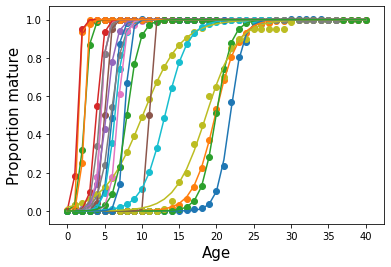

In [27]:
#plot model results against raw data 

#scatter plot of mat and age data
[plt.scatter(AGE[mdata.Stock_Year.values==s], MAT[mdata.Stock_Year.values==s]) for s in StockYr]
#plot ogives with median S and mu_a50 values
[plt.plot(xr, 1/(1+np.exp(-s*(xr-a)))) for s,a in zip(μSs2,μa50s2)]
#make plot pretty
plt.xlabel('Age',fontsize=15)
plt.ylabel('Proportion mature',fontsize=15)

#save results
plt.savefig('mat14_modelfit.jpg',dpi=300);